# RASCIL notebook for pipeline processing of eMERLIN data

In [1]:
import json

import time

from erp.functions.support import start_eMRP_dict, get_logger, get_defaults, find_run_steps
from erp.functions.imaging_steps import *

from rascil.workflows.rsexecute.execution_support import rsexecute

current_version = "0.0.1"

In [ ]:
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)

# Define the steps we want to execute

In [2]:
run_steps = ["load_ms", "average_channels", "convert_stokesI", "create_images",
"weight", "ical", "write_images", "write_gaintables", "write_ms"]

# Initialize eMRP dictionary:
eMRP = start_eMRP_dict('./')

logger = get_logger()

start_epoch = time.asctime()
logger.info("eMERLIN RASCIL imaging pipeline, started at  %s" % start_epoch)

2020-03-03 13:08:23 | INFO | eMERLIN RASCIL imaging pipeline, started at  Tue Mar  3 13:08:23 2020


In [3]:
defaults_file = 'default_params.json'
logger.info('Loading default parameters from {0}:'.format(defaults_file))
eMRP['defaults'] = json.loads(open(defaults_file).read())

# Steps to run:
eMRP['input_steps'] = find_run_steps(eMRP, run_steps, skip_steps=[])

# Pipeline processes, inputs are read from the inputs dictionary

eMRP = get_defaults(eMRP)

2020-03-03 13:08:23 | INFO | Loading default parameters from default_params.json:
2020-03-03 13:08:23 | INFO | Step selection
2020-03-03 13:08:23 | INFO | run_steps : ['load_ms', 'average_channels', 'convert_stokesI', 'create_images', 'weight', 'ical', 'write_images', 'write_gaintables', 'write_ms']
2020-03-03 13:08:23 | INFO | skip_steps: []
2020-03-03 13:08:23 | INFO | Sorted list of steps to execute:
2020-03-03 13:08:23 | INFO | initialize_pipeline: 0
2020-03-03 13:08:23 | INFO | list_ms         : 0
2020-03-03 13:08:23 | INFO | load_ms         : 1
2020-03-03 13:08:23 | INFO | flag            : 0
2020-03-03 13:08:23 | INFO | plot_vis        : 0
2020-03-03 13:08:23 | INFO | average_channels: 1
2020-03-03 13:08:23 | INFO | get_advice      : 0
2020-03-03 13:08:23 | INFO | convert_stokesI : 1
2020-03-03 13:08:23 | INFO | create_images   : 1
2020-03-03 13:08:23 | INFO | weight          : 1
2020-03-03 13:08:23 | INFO | cip             : 0
2020-03-03 13:08:23 | INFO | ical            : 1
20

In [4]:
initialize_pipeline(eMRP, get_logger=get_logger)

2020-03-03 13:08:23 | INFO | Distributed processing using Dask


In [5]:
bvis_list = None
if eMRP['input_steps']['list_ms'] > 0:
    list_ms(eMRP)

In [6]:
if eMRP['input_steps']['load_ms'] > 0:
    bvis_list = load_ms(eMRP)

2020-03-03 13:08:26 | INFO | Loading Measurement Set ../../data/3C277.1C.16channels.ms


In [7]:
if eMRP['input_steps']['flag'] > 0:
    bvis_list = flag(bvis_list, eMRP)

In [8]:
if eMRP['input_steps']['average_channels'] > 0:
    bvis_list = average_channels(bvis_list, eMRP)

2020-03-03 13:08:26 | INFO | Averaging by 1 channels within spectral windows


In [9]:
if eMRP['input_steps']['plot_vis'] > 0:
    plot_vis(bvis_list, eMRP)

In [10]:
if eMRP['input_steps']['get_advice'] > 0:
    advice = get_advice(bvis_list, eMRP)

In [11]:
model_list = list()
if eMRP['input_steps']['create_images'] > 0:
    model_list = create_images(bvis_list, eMRP)

2020-03-03 13:08:26 | INFO | Creating template images


In [12]:
if eMRP['input_steps']['weight'] > 0:
    bvis_list = weight(bvis_list, model_list, eMRP)

2020-03-03 13:08:26 | INFO | Applying uniform weighting


In [13]:
if eMRP['input_steps']['cip'] > 0:
    results = cip(bvis_list, model_list, eMRP)
    results = rsexecute.compute(results, sync=True)
    if eMRP['input_steps']['write_images'] > 0:
        write_images(eMRP, 'cip', results)

2020-03-03 13:08:26 | INFO | Processing with RASCIL ICAL pipeline
2020-03-03 13:10:11 | INFO | Forming 1 moment images from 16 spws
2020-03-03 13:10:11 | INFO | Quality assessment:
	Origin: qa_image
	Context: .//RASCIL_1252+5634_ical_deconvolved_moment0
	Data:
		shape: '(1, 1, 256, 256)'
		max: '0.6377191443209026'
		min: '-0.06236358061994551'
		maxabs: '0.6377191443209026'
		rms: '0.004511932043009013'
		sum: '7.496908893239846'
		medianabs: '0.0'
		medianabsdevmedian: '0.0'
		median: '0.0'

2020-03-03 13:10:12 | INFO | Quality assessment:
	Origin: qa_image
	Context: .//RASCIL_1252+5634_ical_residual_moment0
	Data:
		shape: '(1, 1, 256, 256)'
		max: '0.046889507509149934'
		min: '-0.04675440850639005'
		maxabs: '0.046889507509149934'
		rms: '0.011617966473720572'
		sum: '-2.225727669454331'
		medianabs: '0.00686719869905456'
		medianabsdevmedian: '0.006864281162598461'
		median: '-8.86811084589838e-05'

2020-03-03 13:10:12 | INFO | Quality assessment:
	Origin: qa_image
	Context: .//R

<Figure size 432x288 with 0 Axes>

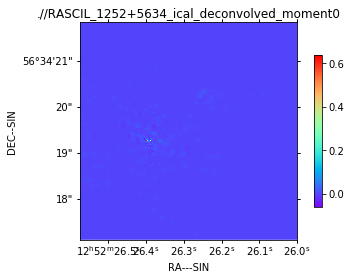

<Figure size 432x288 with 0 Axes>

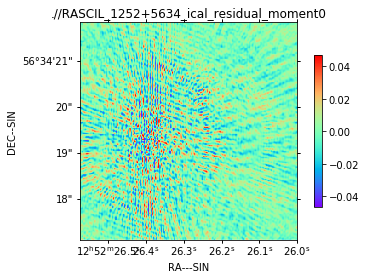

<Figure size 432x288 with 0 Axes>

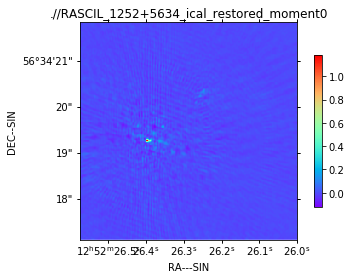

<Figure size 432x288 with 0 Axes>

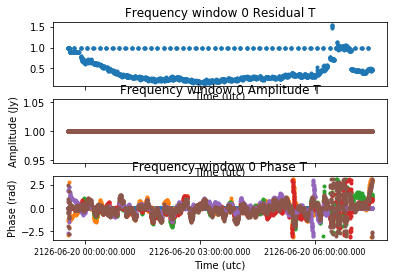

<Figure size 432x288 with 0 Axes>

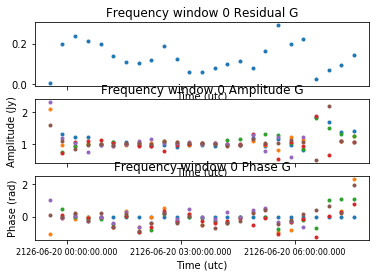

In [14]:
if eMRP['input_steps']['ical'] > 0:
    results = ical(bvis_list, model_list, eMRP)
    bvis_list, results = rsexecute.compute(results, sync=True)
    if eMRP['input_steps']['write_images'] > 0:
        write_images(eMRP, 'ical', results[0:3])
    if eMRP['input_steps']['write_gaintables'] > 0:
        write_gaintables(eMRP, 'ical', results[3])

In [15]:
if eMRP['input_steps']['write_ms'] > 0:
    bvis_list = apply_calibration(results[3], bvis_list, eMRP)
    write_ms(bvis_list, eMRP)

stop_epoch = time.asctime()
logger.info("eMERLIN RASCIL imaging pipeline, started at  %s" % start_epoch)
logger.info("eMERLIN RASCIL imaging pipeline, finished at %s" % stop_epoch)





2020-03-03 13:10:18 | INFO | Combining across spectral windows
2020-03-03 13:10:18 | INFO | Writing Measurement Set ../../test_results3C277.1C.avg_test.ms
2020-03-03 13:10:21 | INFO | eMERLIN RASCIL imaging pipeline, started at  Tue Mar  3 13:08:23 2020
2020-03-03 13:10:21 | INFO | eMERLIN RASCIL imaging pipeline, finished at Tue Mar  3 13:10:21 2020
